In [17]:
#Computer Vision Project utilizing mediapipe's pose estimation and face detection to label body language

#installing required modules
import numpy as np
import mediapipe as mp
import cv2
import pandas as pd
import csv
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pickle

In [18]:
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose
mp_face = mp.solutions.face_mesh

pose = mp_pose.Pose(static_image_mode=True)
face = mp_face.FaceMesh(static_image_mode=True)

In [19]:
mp_drawing.DrawingSpec(color = (0,0,255), thickness = 2, circle_radius = 2)
# mp_drawing.draw_landmarks??

DrawingSpec(color=(0, 0, 255), thickness=2, circle_radius=2)

In [20]:
# Folder where dataset is stored
DATA_DIR = "/content/drive/Othercomputers/My Laptop/projects/FlexiSAF/body_pose"
data = []
labels = []

# looping through each label subfolder
for label in os.listdir(DATA_DIR):
    label_path = os.path.join(DATA_DIR, label)
    if not os.path.isdir(label_path):
        continue

    print(f"\n[INFO] Processing label: '{label}'")

    for file in os.listdir(label_path):
        filepath = os.path.join(label_path, file)

        try:
            image = cv2.imread(filepath)
            if image is None:
                raise ValueError("Image is None — possibly unreadable or corrupt.")
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Detect pose and face
            pose_results = pose.process(image_rgb)
            face_results = face.process(image_rgb)

            # Skip images where no landmarks are detected
            if not pose_results.pose_landmarks and not face_results.multi_face_landmarks:
                print(f"[SKIP] No landmarks found in: {file}")
                continue

            row = []

            # Pose landmarks (33 x 3 = 99 features)
            if pose_results.pose_landmarks:
                for lm in pose_results.pose_landmarks.landmark:
                    row.extend([lm.x, lm.y, lm.z])
            else:
                row.extend([0] * 33 * 3)

            # Face landmarks (468 x 3 = 1404 features)
            if face_results.multi_face_landmarks:
                for lm in face_results.multi_face_landmarks[0].landmark:
                    row.extend([lm.x, lm.y, lm.z])
            else:
                row.extend([0] * 468 * 3)

            data.append(row)
            labels.append(label)

        except Exception as e:
            print(f"[ERROR] Failed to process {file}: {e}")
            continue

pose.close()
face.close()



[INFO] Processing label: 'anxious'
[SKIP] No landmarks found in: images3.jpg
[SKIP] No landmarks found in: images32.jpg
[SKIP] No landmarks found in: images18.jpg
[SKIP] No landmarks found in: image34.png
[SKIP] No landmarks found in: images4.jpg
[SKIP] No landmarks found in: images10.jpg
[SKIP] No landmarks found in: images52.jpg
[SKIP] No landmarks found in: nervousguy.jpg
[SKIP] No landmarks found in: images132.jpg
[SKIP] No landmarks found in: images62.jpg
[SKIP] No landmarks found in: images105.jpg
[SKIP] No landmarks found in: images87.jpg
[SKIP] No landmarks found in: images64.jpg
[SKIP] No landmarks found in: images131.jpg
[SKIP] No landmarks found in: images41.jpg
[SKIP] No landmarks found in: images95.jpg
[SKIP] No landmarks found in: images81.jpg
[SKIP] No landmarks found in: images68.jpg
[SKIP] No landmarks found in: images42.jpg
[SKIP] No landmarks found in: images120.jpg
[SKIP] No landmarks found in: COLOURBOX66631633.jpg
[SKIP] No landmarks found in: images75.jpg
[SKIP]

In [21]:
# Saving the detected landmarks as a DataFrame
print(f"Total usable samples: {len(data)}")
df = pd.DataFrame(data)
df['label'] = labels
print(df.info())
df.head()

Total usable samples: 423
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423 entries, 0 to 422
Columns: 1504 entries, 0 to label
dtypes: float64(1503), object(1)
memory usage: 4.9+ MB
None


,0,1,2,3,4,5,6,7,8,9,...,1494,1495,1496,1497,1498,1499,1500,1501,1502,label
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.541523,0.460888,-0.015703,0.575225,0.453325,0.003172,0.580109,0.447073,0.003951,anxious
1,0.279081,0.288269,-0.596533,0.307941,0.238307,-0.564221,0.321543,0.235494,-0.564301,0.334317,...,0.265776,0.273882,-0.016959,0.302777,0.261080,-0.021118,0.306062,0.256475,-0.022488,anxious
2,0.656797,0.420597,-0.592034,0.673677,0.383206,-0.552697,0.683069,0.382629,-0.552724,0.692871,...,0.657697,0.390250,-0.008840,0.693176,0.382128,-0.018115,0.697835,0.375785,-0.019298,anxious
3,0.497940,0.395916,-0.772590,0.533211,0.301679,-0.749830,0.556113,0.296109,-0.749810,0.579041,...,0.495688,0.325585,-0.032164,0.555351,0.303052,-0.049407,0.560614,0.295431,-0.052529,anxious
4,0.495883,0.355388,-1.355805,0.537461,0.264737,-1.290592,0.559647,0.262682,-1.290691,0.582035,...,0.510263,0.288913,-0.011320,0.579720,0.266184,0.012499,0.585913,0.259601,0.012561,anxious


In [28]:
df['label'].value_counts()

,count
label,
anxious,219
folded_arms,131
drowsy,73


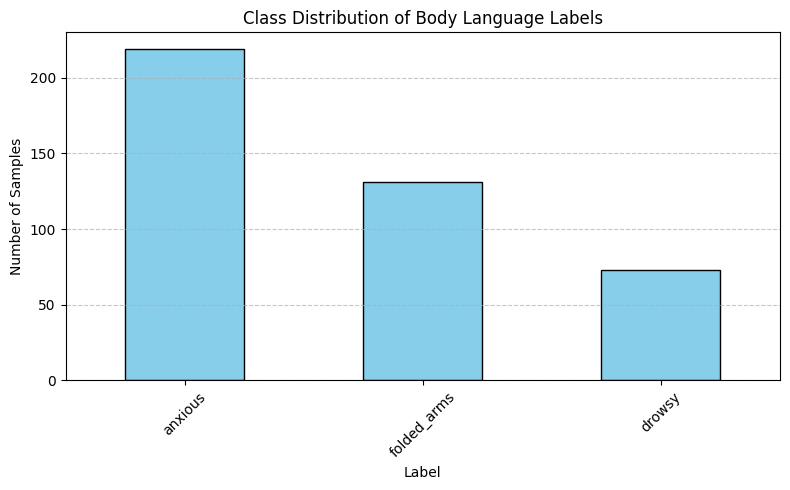

In [29]:
#there might be a bit of bias in the preidction due to data imbalance
import matplotlib.pyplot as plt

class_counts = df['label'].value_counts()

plt.figure(figsize=(8, 5))
class_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title("Class Distribution of Body Language Labels")
plt.xlabel("Label")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [30]:
# saving as a csv file
df.to_csv("body_language_dataset.csv", index=False)

In [31]:
#load csv file
df = pd.read_csv('body_language_dataset.csv')
df.head()

,0,1,2,3,4,5,6,7,8,9,...,1494,1495,1496,1497,1498,1499,1500,1501,1502,label
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.541523,0.460888,-0.015703,0.575225,0.453325,0.003172,0.580109,0.447073,0.003951,anxious
1,0.279081,0.288269,-0.596533,0.307941,0.238307,-0.564221,0.321543,0.235494,-0.564301,0.334317,...,0.265776,0.273882,-0.016959,0.302777,0.261080,-0.021118,0.306062,0.256475,-0.022488,anxious
2,0.656797,0.420597,-0.592034,0.673677,0.383206,-0.552697,0.683069,0.382629,-0.552724,0.692871,...,0.657697,0.390250,-0.008840,0.693176,0.382128,-0.018115,0.697835,0.375785,-0.019298,anxious
3,0.497940,0.395916,-0.772590,0.533211,0.301679,-0.749830,0.556113,0.296109,-0.749810,0.579041,...,0.495688,0.325585,-0.032164,0.555351,0.303052,-0.049407,0.560614,0.295431,-0.052529,anxious
4,0.495883,0.355388,-1.355805,0.537461,0.264737,-1.290592,0.559647,0.262682,-1.290691,0.582035,...,0.510263,0.288913,-0.011320,0.579720,0.266184,0.012499,0.585913,0.259601,0.012561,anxious


In [32]:
X = df.drop('label', axis = 1)
y = df['label']

In [41]:
# training and evaluating the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=200, criterion = 'gini', max_features = 'sqrt', class_weight = 'balanced', random_state=42)
clf.fit(X_train, y_train)

print("Training Accuracy:", clf.score(X_train, y_train))
print("Testing Accuracy:", clf.score(X_test, y_test))

Training Accuracy: 1.0
Testing Accuracy: 0.8705882352941177


In [65]:
import random
sample_images = []

# Randomly picking images
for label in os.listdir(DATA_DIR):
    label_path = os.path.join(DATA_DIR, label)
    if os.path.isdir(label_path):
        files = os.listdir(label_path)
        if files:
          for i in range(5):
            chosen = random.choice(files)
            sample_images.append((os.path.join(label_path, chosen), label))

sample_images

[('/content/drive/Othercomputers/My Laptop/projects/FlexiSAF/body_pose/anxious/images73.jpg',
  'anxious'),
 ('/content/drive/Othercomputers/My Laptop/projects/FlexiSAF/body_pose/anxious/images79.jpg',
  'anxious'),
 ('/content/drive/Othercomputers/My Laptop/projects/FlexiSAF/body_pose/anxious/images111.jpg',
  'anxious'),
 ('/content/drive/Othercomputers/My Laptop/projects/FlexiSAF/body_pose/anxious/images78.jpg',
  'anxious'),
 ('/content/drive/Othercomputers/My Laptop/projects/FlexiSAF/body_pose/anxious/images104.jpg',
  'anxious'),
 ('/content/drive/Othercomputers/My Laptop/projects/FlexiSAF/body_pose/drowsy/image10.jpeg',
  'drowsy'),
 ('/content/drive/Othercomputers/My Laptop/projects/FlexiSAF/body_pose/drowsy/35443855-tired-sleepy-young-man-yawning.jpg',
  'drowsy'),
 ('/content/drive/Othercomputers/My Laptop/projects/FlexiSAF/body_pose/drowsy/bigstock-Tired-woman-in-front-of-comput-73500745.jpg',
  'drowsy'),
 ('/content/drive/Othercomputers/My Laptop/projects/FlexiSAF/body_pos

In [74]:
def extract_features(image_path):
    image = cv2.imread(image_path)

    if image is None:
        print(f"[ERROR] Unable to read image: {image_path}")
        return None

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Detect pose and face
    pose_results = pose.process(image_rgb)
    face_results = face.process(image_rgb)

    # Skip images where no landmarks are detected
    if not pose_results.pose_landmarks and not face_results.multi_face_landmarks:
        print(f"[SKIP] No landmarks found in: {image_path}")
        return None

    row = []

    # Pose landmarks (33 x 3 = 99 features)
    if pose_results.pose_landmarks:
        for lm in pose_results.pose_landmarks.landmark:
            row.extend([lm.x, lm.y, lm.z])
    else:
        row.extend([0] * 33 * 3)

    # Face landmarks (468 x 3 = 1404 features)
    if face_results.multi_face_landmarks:
        for lm in face_results.multi_face_landmarks[0].landmark:
            row.extend([lm.x, lm.y, lm.z])
    else:
        row.extend([0] * 468 * 3)

    return np.array(row)


In [75]:
import mediapipe as mp

mp_pose = mp.solutions.pose
mp_face = mp.solutions.face_mesh

pose = mp_pose.Pose(static_image_mode=True)
face = mp_face.FaceMesh(static_image_mode=True)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


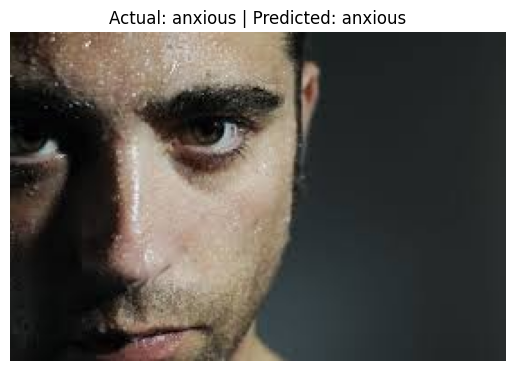

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


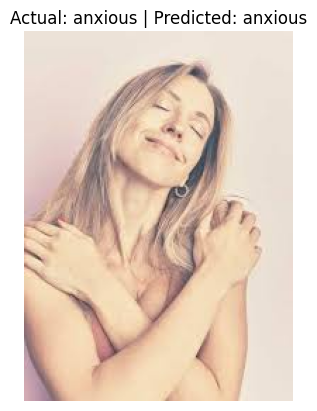

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


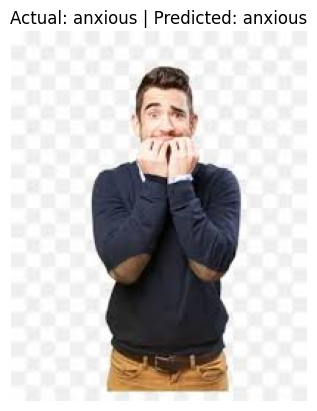

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


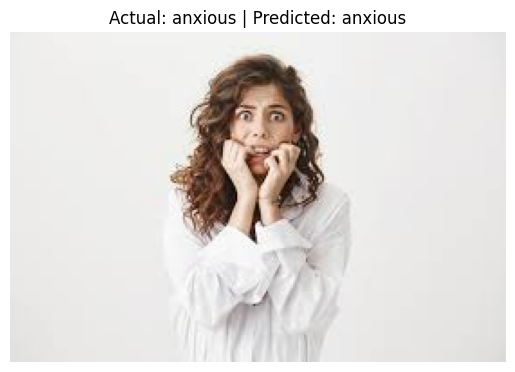

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


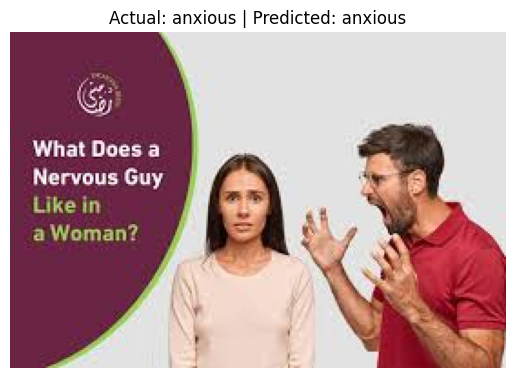

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


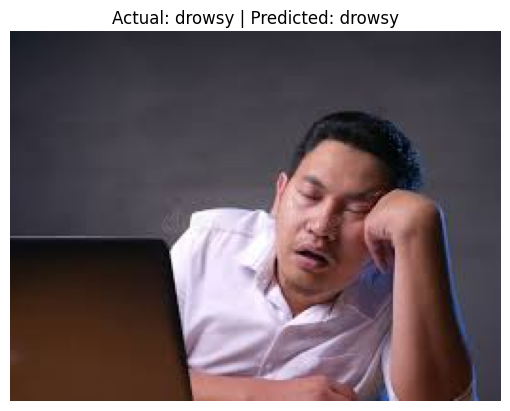

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


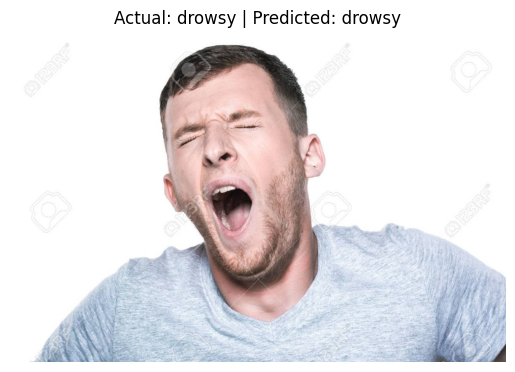

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


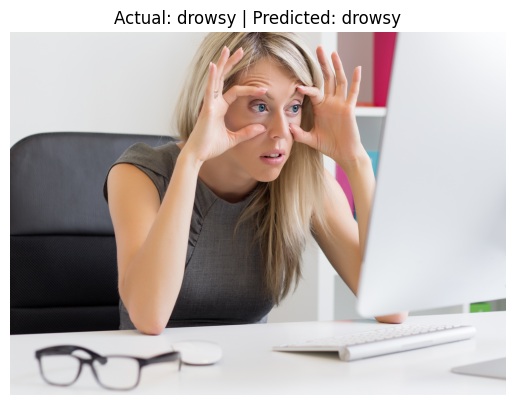

[SKIP] No landmarks found in: /content/drive/Othercomputers/My Laptop/projects/FlexiSAF/body_pose/drowsy/image19.jpeg
[SKIP] Landmarks not detected for /content/drive/Othercomputers/My Laptop/projects/FlexiSAF/body_pose/drowsy/image19.jpeg


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


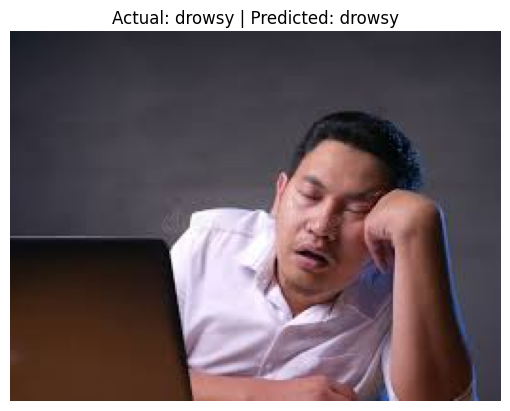

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


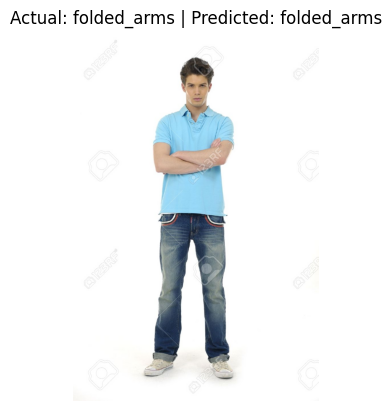

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


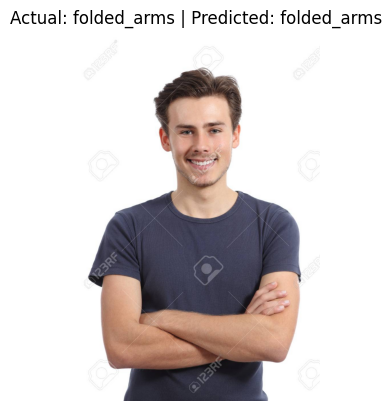

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


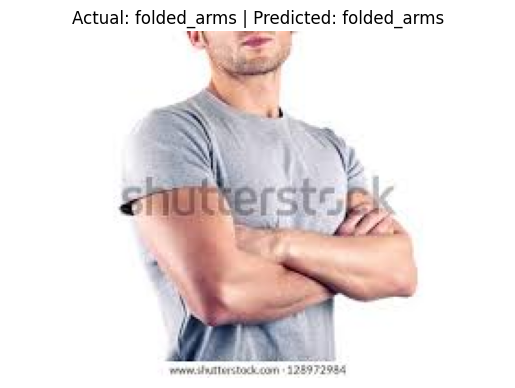

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


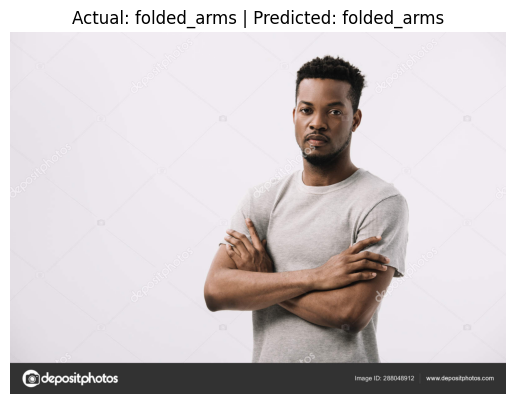

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


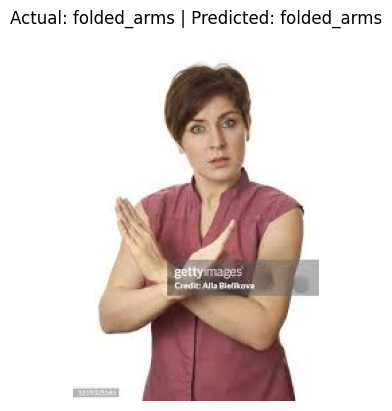

In [76]:
# Predict and visualize
for path, true_label in sample_images:
  features = extract_features(path)
  if features is not None:
    prediction = clf.predict([features])[0]

    img = cv2.imread(path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.imshow(img_rgb)
    plt.title(f"Actual: {true_label} | Predicted: {prediction}")
    plt.axis('off')
    plt.show()
  else:
      print(f"[SKIP] Landmarks not detected for {path}")

In [77]:
with open("pose_face_rf_model.pkl", "wb") as f:
    pickle.dump(clf, f)
# saving the model